# Embedded Regression

In [106]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')

from pathlib import Path

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn import MSELoss

from src.models.torch.embedded_regression import EmbeddedRegression
from src.models.torch.trainer import Trainer
from src.util.data import get_interactions, get_sparsity_factor
from src.util.plot import Plot

plot = Plot()

RATINGS_PATH = Path('../data/ratings_small.csv')
OUTPUT_PATH = Path('../models/embedded_regression.pt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [107]:
ratings = pd.read_csv(RATINGS_PATH)

In [108]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'].values)

movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'].values)

LabelEncoder()

In [109]:
train_ratings, test_ratings = train_test_split(
    ratings,
    test_size=0.01,
    stratify=ratings['userId'].values,
    random_state=42
)

In [110]:
train_interactions = get_interactions(
    train_ratings,
    user_encoder,
    movie_encoder
)

test_interactions = get_interactions(
    test_ratings,
    user_encoder,
    movie_encoder
)

Building interaction matrix: 100%|██████████| 1001/1001 [00:00<00:00, 1034367.65it/s]


In [111]:
train_sparsity = get_sparsity_factor(train_interactions)
test_sparsity = get_sparsity_factor(test_interactions)

In [112]:
print(f'Train sparsity: {(train_sparsity * 100):.3f}%')
print(f'Test sparsity: {(test_sparsity * 100):.3f}%')

Train sparsity: 1.627%
Test sparsity: 0.016%


## Model

In [113]:
model = EmbeddedRegression(
    train_interactions,
    n_factors=20,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
)

In [114]:
trainer = Trainer(
    loss=MSELoss(),
    regularizers=[],
    lr=1e-4,
    weight_decay=1e-4,
    epochs=100,
    batch_size=5_000
)

train_loss_history, test_loss_history = trainer.train(
    model,
    train_interactions,
    test_interactions,
    is_sparse=False
)

Training: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


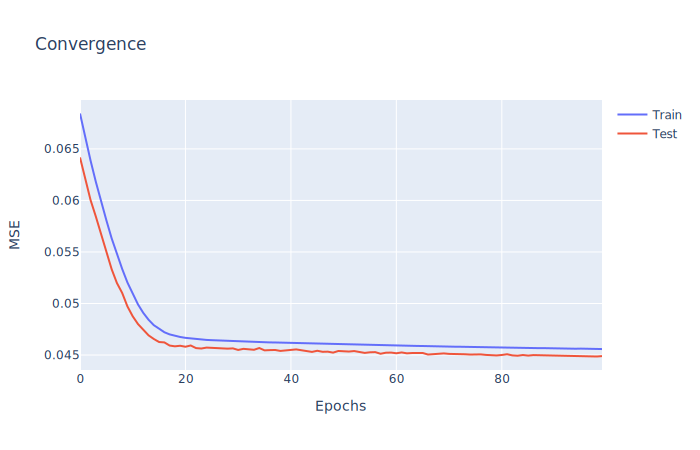

In [115]:
plot.convergence(
    losses=[train_loss_history, test_loss_history],
    names=['Train', 'Test'],
    xaxis_title='Epochs',
    yaxis_title='MSE'
)

In [116]:
torch.save(model, OUTPUT_PATH)